In [14]:
using Pkg
Pkg.activate("./")
using Oceananigans, CairoMakie, LaTeXStrings

  Activating project at `~/development/TimestepperTestCases.jl`


In [15]:
using Oceananigans.Models.VarianceDissipationComputations
using Oceananigans.TimeSteppers: SplitRungeKuttaTimeStepper, QuasiAdamsBashforth2TimeStepper
using KernelAbstractions: @kernel, @index
using GLMakie

N = 200

# 1D grid constructions
grid = RectilinearGrid(size=N, x=(-1, 1), halo=7, topology = (Periodic, Flat, Flat))

# the initial condition
@inline G(x, β, z) = exp(-β*(x - z)^2)
@inline F(x, α, a) = √(max(1 - α^2*(x-a)^2, 0.0))

Z = -0.7
δ = 0.005
β = log(2)/(36*δ^2)
a = 0.5
α = 10

@inline function c₀(x)
    if x <= -0.6 && x >= -0.8
        return 1/6*(G(x, β, Z-δ) + 4*G(x, β, Z) + G(x, β, Z+δ))
    elseif x <= -0.2 && x >= -0.4
        return 1.0
    elseif x <= 0.2 && x >= 0.0
        return 1.0 - abs(10 * (x - 0.1))
    elseif x <= 0.6 && x >= 0.4
        return 1/6*(F(x, α, a-δ) + 4*F(x, α, a) + F(x, α, a+δ))
    else
        return 0.0
    end
end

@kernel function _compute_dissipation!(Δtc², c⁻, c, Δt)
    i, j, k = @index(Global, NTuple)
    @inbounds begin
        Δtc²[i, j, k] = (c[i, j, k]^2 - c⁻[i, j, k]^2) / Δt
        c⁻[i, j, k]   = c[i, j, k]
    end
end

function compute_tracer_dissipation!(sim)
    c    = sim.model.tracers.c
    c⁻   = sim.model.auxiliary_fields.c⁻
    Δtc² = sim.model.auxiliary_fields.Δtc²
    Oceananigans.Utils.launch!(CPU(), sim.model.grid, :xyz,
                               _compute_dissipation!,
                               Δtc², c⁻, c, sim.Δt)

    return nothing
end

cᵢ = CenterField(grid)
set!(cᵢ, c₀)

tracer_advection = WENO(order=7)
closure = nothing # ScalarDiffusivity(κ=1e-5)
velocities = PrescribedVelocityFields(u=1)
    
function run_simulation(ts, timestepper; χ=nothing, velocities=velocities)   
    c⁻    = CenterField(grid)
    Δtc²  = CenterField(grid)     

    model = HydrostaticFreeSurfaceModel(; grid, 
                                          timestepper, 
                                          velocities, 
                                          tracer_advection, 
                                          closure, 
                                          tracers=:c,
                                          auxiliary_fields=(; Δtc², c⁻))
                                       
    if timestepper == :QuasiAdamsBashforth2 && χ !== nothing
        model.timestepper.χ = χ
    end

    set!(model, c=c₀)
    set!(model.auxiliary_fields.c⁻, c₀)

    if timestepper == :SplitRungeKutta3
        Δt = 0.5 * minimum_xspacing(grid)
    elseif timestepper == :QuasiAdamsBashforth2
        Δt = 0.2 * minimum_xspacing(grid)
    elseif timestepper == :D0
        Δt = 1 * minimum_xspacing(grid)
    end

    @show Δt
    sim = Simulation(model; Δt, stop_time=12)

    ϵ = VarianceDissipation(:c, grid)
    f = Oceananigans.Models.VarianceDissipationComputations.flatten_dissipation_fields(ϵ)

    outputs = merge((; c = model.tracers.c, Δtc² = model.auxiliary_fields.Δtc²), f)
    add_callback!(sim, ϵ, IterationInterval(1))
    add_callback!(sim, compute_tracer_dissipation!, IterationInterval(1))

    iteration_interval = ceil(Int, 0.12 / Δt)

    sim.output_writers[:solution] = JLD2Writer(model, outputs;
                                               filename="one_d_simulation_$(ts).jld2",
                                               schedule=IterationInterval(iteration_interval),
                                               overwrite_existing=true)
    
    run!(sim)

    c    = FieldTimeSeries("one_d_simulation_$(ts).jld2", "c")
    Δtc² = FieldTimeSeries("one_d_simulation_$(ts).jld2", "Δtc²")
    Acx  = FieldTimeSeries("one_d_simulation_$(ts).jld2", "Acx")
    Dcx  = FieldTimeSeries("one_d_simulation_$(ts).jld2", "Dcx")

    Nt = length(c.times)

    ∫closs = abs.([sum(interior(Δtc²[i], :, 1, 1) .* grid.Δxᶜᵃᵃ) for i in 2:Nt-1])
    ∫A     = abs.([sum(interior(Acx[i] , :, 1, 1))               for i in 2:Nt-1])
    ∫D     = abs.([sum(interior(Dcx[i] , :, 1, 1))               for i in 2:Nt-1])
    ∫T     = ∫D .+ ∫A
    times  = c.times[2:end-1]

    return (; c, Δtc², Acx, Dcx, ∫closs, ∫A, ∫D, ∫T, times)
end

using LaTeXStrings

cases = Dict()

cases["AB1"]  = run_simulation(:AB2, :QuasiAdamsBashforth2, χ=0.1)
cases["RK3"]  = run_simulation(:RK3, :SplitRungeKutta3)
cases["ICC"]  = run_simulation(:D0,  :SplitRungeKutta3, velocities=PrescribedVelocityFields())

Δt = 0.002


[ Info: Initializing simulation...
[ Info:     ... simulation initialization complete (910.821 ms)
[ Info: Executing initial time step...
[ Info:     ... initial time step complete (3.717 seconds).
[ Info: Simulation is stopping after running for 6.065 seconds.
[ Info: Simulation time 12 seconds equals or exceeds stop time 12 seconds.
┌ Warning: Split barotropic-baroclinic time stepping with SplitRungeKuttaTimeStepper is experimental.
│ Use at own risk, and report any issues encountered at [https://github.com/CliMA/Oceananigans.jl/issues](https://github.com/CliMA/Oceananigans.jl/issues).
└ @ Oceananigans.TimeSteppers ~/development/TestOceananigans.jl/src/TimeSteppers/split_runge_kutta.jl:60


Δt = 0.005


[ Info: Initializing simulation...
[ Info:     ... simulation initialization complete (282.666 ms)
[ Info: Executing initial time step...
[ Info:     ... initial time step complete (1.300 seconds).
[ Info: Simulation is stopping after running for 2.219 seconds.
[ Info: Simulation time 12 seconds equals or exceeds stop time 12 seconds.
┌ Warning: Split barotropic-baroclinic time stepping with SplitRungeKuttaTimeStepper is experimental.
│ Use at own risk, and report any issues encountered at [https://github.com/CliMA/Oceananigans.jl/issues](https://github.com/CliMA/Oceananigans.jl/issues).
└ @ Oceananigans.TimeSteppers ~/development/TestOceananigans.jl/src/TimeSteppers/split_runge_kutta.jl:60


Δt = 0.005


[ Info: Initializing simulation...
[ Info:     ... simulation initialization complete (226.009 ms)
[ Info: Executing initial time step...
[ Info:     ... initial time step complete (993.737 ms).
[ Info: Simulation is stopping after running for 2.307 seconds.
[ Info: Simulation time 12 seconds equals or exceeds stop time 12 seconds.


(c = 200×1×1×101 FieldTimeSeries{InMemory} located at (Center, Center, Center) of c at one_d_simulation_D0.jld2
├── grid: 200×1×1 RectilinearGrid{Float64, Periodic, Flat, Flat} on CPU with 7×0×0 halo
├── indices: (:, :, :)
├── time_indexing: Linear()
├── backend: InMemory()
├── path: one_d_simulation_D0.jld2
├── name: c
└── data: 214×1×1×101 OffsetArray(::Array{Float64, 4}, -6:207, 1:1, 1:1, 1:101) with eltype Float64 with indices -6:207×1:1×1:1×1:101
    └── max=1.0, min=0.0, mean=0.243311, Δtc² = 200×1×1×101 FieldTimeSeries{InMemory} located at (Center, Center, Center) of Δtc² at one_d_simulation_D0.jld2
├── grid: 200×1×1 RectilinearGrid{Float64, Periodic, Flat, Flat} on CPU with 7×0×0 halo
├── indices: (:, :, :)
├── time_indexing: Linear()
├── backend: InMemory()
├── path: one_d_simulation_D0.jld2
├── name: Δtc²
└── data: 214×1×1×101 OffsetArray(::Array{Float64, 4}, -6:207, 1:1, 1:1, 1:101) with eltype Float64 with indices -6:207×1:1×1:1×1:101
    └── max=0.0, min=0.0, mean=0.0, Acx

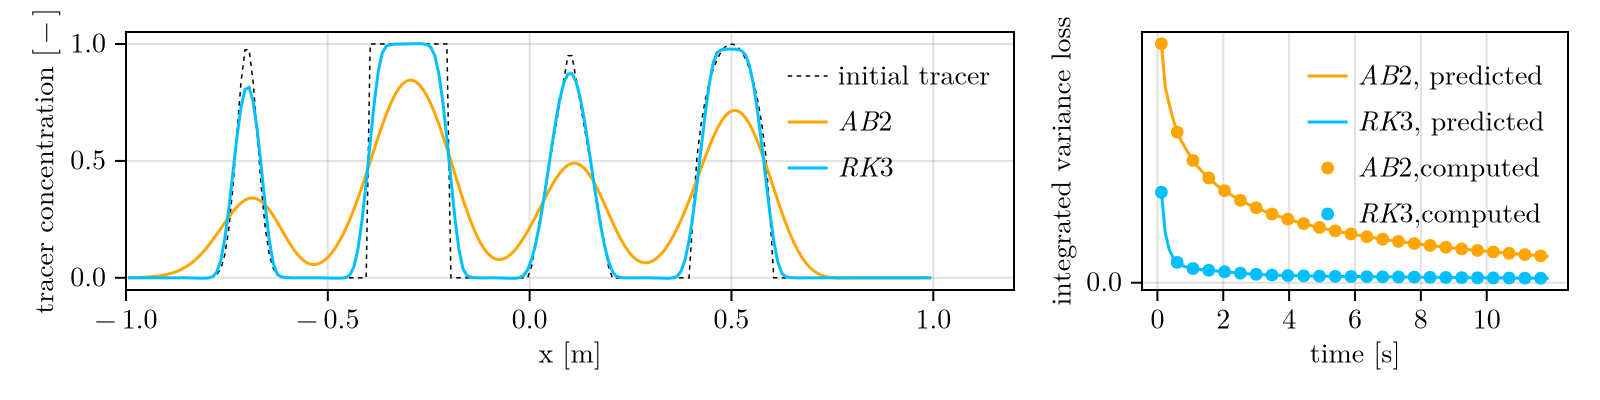

CairoMakie.Screen{IMAGE}


In [26]:
c1 = :deepskyblue 
c3 = :orange1 

fig = Figure(size = (800, 200))
ax  = Axis(fig[1, 1:2], 
           xlabel=L"\text{x [m]}", 
           ylabel=L"\text{tracer concentration [-]}",
           xticks=([-1, -0.5, 0, 0.5, 1], latexstring.(string.([-1, -0.5, 0, 0.5, 1]))),
           yticks=([0, 0.5, 1], latexstring.(string.([0, 0.5, 1]))))

x, y, z = nodes(cases["AB1"].c)

lines!(ax, x, interior(cases["ICC"].c[end], :, 1, 1), label = L"\text{initial tracer}", color = :black, linestyle = :dash, linewidth = 0.75)
lines!(ax, x, interior(cases["AB1"].c[end], :, 1, 1), label = L"AB2", color = c3)
lines!(ax, x, interior(cases["RK3"].c[end], :, 1, 1), label = L"RK3", color = c1)
axislegend(ax, position=:rt, framevisible=false)
xlims!(ax, -1, 1.2)
ax2 = Axis(fig[1, 3], 
           xlabel=L"\text{time [s]}", 
           ylabel=L"\text{integrated variance loss}",
           xticks=([0, 2, 4, 6, 8, 10], latexstring.(string.([0, 2, 4, 6, 8, 10]))),
           yticks=([0, 0.2, 0.4, 0.6], latexstring.(string.([0, 0.2, 0.4, 0.6]))))

lines!(ax2,   cases["AB1"].times, cases["AB1"].∫T, label = L"AB2, \ \text{predicted}", color = c3)
lines!(ax2,   cases["RK3"].times, cases["RK3"].∫T, label = L"RK3, \ \text{predicted}", color = c1)
scatter!(ax2, cases["AB1"].times[1:4:end], cases["AB1"].∫closs[1:4:end], label = L"AB2, \text{computed}", color = c3)
scatter!(ax2, cases["RK3"].times[1:4:end], cases["RK3"].∫closs[1:4:end], label = L"RK3, \text{computed}", color = c1)
axislegend(ax2, position=:rt, framevisible=false)

path = "/Users/simonesilvestri/Dropbox (MIT)/Apps/Overleaf/timestepper/"

CairoMakie.save(path * "one-d-advection.pdf", fig)
display(fig)